# Neural Network

*fancy introduction*

In [28]:
# library dependencies
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import lzma
import pickle
from sklearn.model_selection import train_test_split
import keras
from keras import layers
import tensorflow as tf
import keras_tuner

The following methods read the prepared data files from the pre processing step and return the lists.

In [2]:
# method to store data as serialized binary structure lzma compressed
def can_pickles(data, filename):
    with lzma.LZMAFile(filename, 'wb') as f:
        pickle.dump(data, f, pickle.DEFAULT_PROTOCOL)

# method to retrieve data from a compressed pickle file (created with the method above)
def uncan_pickles(filename):
    with lzma.LZMAFile(filename, 'rb') as f:
        return pickle.load(f)

## Basic Neural Network

*explain it in more detail*

X holds a list of sequences one hot encoded

y holds a list of PTR values as floats

In [3]:
# read the prepared data back
X = uncan_pickles('../data/onehot_x_lung.pickle.xz')
y = uncan_pickles('../data/onehot_y_lung.pickle.xz')

In [4]:
# pad add sequence entries to the same length
# done here for simplicity to find a good neural network
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, padding="post")

In [5]:
# convert type of target values from string to float
y = np.array(y).astype(float)

Random sample from X and y.

In [6]:
X[0]

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [7]:
y[0]

7.544

In [8]:
# count of input sequences
len(X)

8201

### Baseline PTR

There is no common sense approach in finding a baseline for the protein-to-mRNA ratio of a particular mRNA sequence. This is what the *Basic Neural Network* approach is for - to determin a baseline and see if a slightly adapted neural network with feature engineered input can provide better predictions.

But what can be done is to simply check the value range of the target PTRs, calculate mean and standard deviation. Given that the standard deviation is  small (12.5% of the value range) one can (stupidly) predict the mean value every time. From that it's possible to calculate the Mean Absolute Error (MAE) and compare that to the following neural network output.

In [9]:
# get some idea of the range of the PTR in the selected SAMPLE
print(np.min(y), np.max(y), np.mean(y), np.std(y))

1.552 8.587 4.973957444214121 0.8835629329175175


In [10]:
# simple/dumb baseline mean absolute error of always predicting 4.974
mae = np.mean(np.abs(np.array(y) - 4.974))
mae

0.7055145713937325

### Data Preparation

Split data in train and test subsets and then split the train subset again in train and validation.

A simple verification if the X and y correlation are preserved on the split is done.

In [11]:
# split in train and test sub sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=1202)

In [12]:
# split the train set again in train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1202)

In [13]:
# get a sample
X_train[1]

array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

In [14]:
# get the matching target
y_train[1]

4.901

In [15]:
# find the target value in the raw dataset
for i in range(len(y)):
    if y[i] == 3.746:
        print(i)

6663


In [16]:
# compare if the raw dataset entry matches the subset entry
if X_padded[6663].all() == X_train[1].all():
    print('OK')

OK


### Model Building

In [17]:
def zrimec_model():
    inputs = layers.Input(shape=(7999, 4))

    conv1 = layers.Conv1D(
        filters=32,
        kernel_size=10,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs)
    norm1 = layers.BatchNormalization()(conv1)
    drop1 = layers.Dropout(
        rate=0.1
    )(norm1)
    pool1 = layers.MaxPooling1D(
        pool_size=4,
        strides=4
    )(drop1)
    conv2 = layers.Conv1D(
        filters=64,
        kernel_size=10,
        strides=1,
        activation='relu',
        padding='valid'
    )(pool1)
    norm2 = layers.BatchNormalization()(conv2)
    drop2 = layers.Dropout(
        rate=0.1
    )(norm2)
    pool2 = layers.MaxPooling1D(
        pool_size=4,
        strides=4
    )(drop2)
    conv3 = layers.Conv1D(
        filters=128,
        kernel_size=10,
        strides=1,
        activation='relu',
        padding='valid'
    )(pool2)
    norm3 = layers.BatchNormalization()(conv3)
    drop3 = layers.Dropout(
        rate=0.1
    )(norm3)
    pool3 = layers.MaxPooling1D(
        pool_size=4,
        strides=4
    )(drop3)
    flat = layers.Flatten()(pool3)
    dense = layers.Dense(
        units=64,
        activation='relu'
    )(flat)
    norm4 = layers.BatchNormalization()(flat)
    drop4 = layers.Dropout(
        rate=0.1
    )(norm4)
    outputs = layers.Dense(
        units=1
    )(drop4)

    model = keras.Model(inputs=inputs, outputs=outputs, name='ZrimecModel')
    return model

In [18]:
def danq_model():
    inputs = layers.Input(shape=(7999, 4))

    conv = layers.Conv1D(
        filters=320,
        kernel_size=26,
        padding='valid',
        activation='relu'
    )(inputs)
    pool = layers.MaxPooling1D(
        pool_size=13,
        strides=13
    )(conv)
    drop1 = layers.Dropout(
        rate=0.2
    )(pool)

    forward_layer = layers.LSTM(units=320, return_sequences=True)
    backward_layer = layers.LSTM(units=320, return_sequences=True, go_backwards=True)
    bilstm = layers.Bidirectional(
        forward_layer, backward_layer=backward_layer
    )(drop1)
    drop2 = layers.Dropout(
        rate=0.2
    )(bilstm)
    flat = layers.Flatten()(drop2)
    dense1 = layers.Dense(
        units=925,
        activation='relu'
    )(flat)
    outputs = layers.Dense(
        units=1
    )(dense1)
    
    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='DanQModel')
    
    return model

In [19]:
def danq_refined_model():
    inputs = layers.Input(shape=(7999, 4))

    conv = layers.Conv1D(
        filters=64,
        kernel_size=3,
        padding='valid',
        activation='relu'
    )(inputs)
    pool = layers.MaxPooling1D(
        pool_size=4,
        strides=4
    )(conv)
    norm = layers.BatchNormalization()(pool)
    # drop1 = layers.Dropout(
    #     rate=0.2
    # )(pool)

    bilstm = layers.Bidirectional(
        layers.LSTM(units=64, return_sequences=True, recurrent_dropout=0.25),
        # merge_mode='mul'
    )(norm)
    drop2 = layers.Dropout(
        rate=0.5
    )(bilstm)
    flat = layers.Flatten()(drop2)
    dense1 = layers.Dense(
        units=64,
        activation='relu'
    )(flat)
    outputs = layers.Dense(
        units=1
    )(dense1)
    
    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='DanQRefModel')
    
    return model

In [29]:
def dan_zrimec_model():
    # input
    # setting fixed shape since the sequences are padded to the max length (threshold of preproc2)
    inputs = layers.Input(shape=(7999, 4))
    # 1D convolution
    conv = layers.Conv1D(
        filters=320, 
        kernel_size=26, 
        strides=1, 
        activation='relu'
    )(inputs)
    # batch normalization
    norm = layers.BatchNormalization()(conv)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=13,
        strides=13
    )(norm)
    # dropout
    drop = layers.Dropout(rate=0.1)(pool)
    # bi-directional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=320, 
            dropout=0,
            return_sequences=True,
        ),
        merge_mode='mul',
        # input_shape=(8000, 4),
    )(drop)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=13,
        strides=13,
    )(bilstm)
    drop = layers.Dropout(rate=0.1)(pool)
    # flatten
    flat = layers.Flatten()(drop)
    # fully connected
    dense = layers.Dense(
        units=64,
        activation='relu',
    )(flat)
    # batch normalization
    norm = layers.BatchNormalization()(dense)
    # dropout
    drop = layers.Dropout(rate=0.1)(norm)
    # dense
    outputs = layers.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='BaselineModel')
    
    return model

In [21]:
def augur_model():
    inputs = layers.Input(shape=(7999, 4))
    conv = layers.Conv1D(
        filters=64,
        kernel_size=3,
        padding='valid',
        activation='relu'
    )(inputs)
    bilstm = layers.Bidirectional(layers.LSTM(units=64, recurrent_dropout=0.25))(conv)
    drop1 = layers.Dropout(rate=0.2)(bilstm)
    outputs = layers.Dense(units=1)(drop1)
    
    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='AugurModel')
    
    return model

In [31]:
def plot_loss(hist, start_epoch=1):
    history_dict = hist.history
    loss_values = history_dict["loss"][start_epoch-1:]
    val_loss_values = history_dict["val_loss"][start_epoch-1:]
    epochs = range(start_epoch, len(history_dict["loss"]) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [24]:
def model_test(model, epochs=5, plot_epoch_start=1):
    model.summary()
    
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        # optimizer=keras.optimizers.Adam(learning_rate=0.1, beta_1=0.999, beta_2=0.99, epsilon=1e-6),
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.MeanAbsolutePercentageError(), keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()],
    )
    
    history = model.fit(
        X_train, 
        y_train, 
        batch_size=64, 
        epochs=epochs, 
        validation_data=(X_val, y_val), 
        # callbacks=callbacks
    )
    
    y_pred = model.predict(X_test)
    print('Random prediction sample (truth, prediction):', y_test[0], y_pred[0])
    
    plot_loss(history, plot_epoch_start)

### Preliminary Model Testing

Model: "ZrimecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7999, 4)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 7990, 32)          1312      
                                                                 
 batch_normalization_4 (Bat  (None, 7990, 32)          128       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 7990, 32)          0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1997, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 1988, 64)          

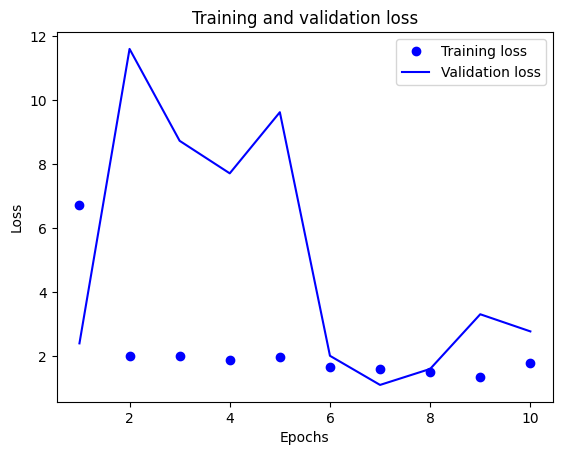

In [26]:
model_test(zrimec_model(), 10)

Model: "DanQModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7999, 4)]         0         
                                                                 
 conv1d_8 (Conv1D)           (None, 7974, 320)         33600     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 613, 320)          0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 613, 320)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 613, 640)          1640960   
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 613, 640)          0 

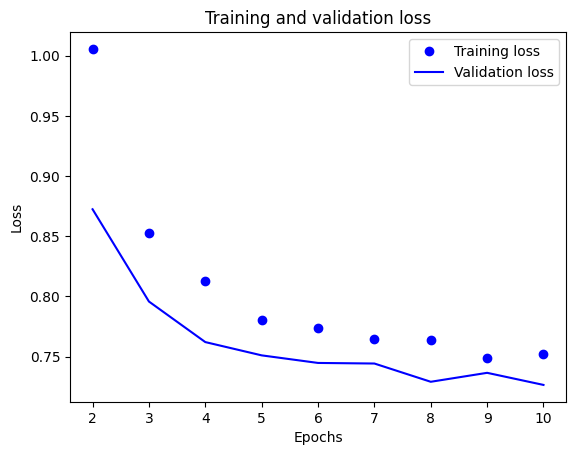

In [32]:
model_test(danq_model(), 10, 2)

Model: "DanQRefModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7999, 4)]         0         
                                                                 
 conv1d_9 (Conv1D)           (None, 7997, 64)          832       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1999, 64)          0         
 g1D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 1999, 64)          256       
 chNormalization)                                                
                                                                 
 bidirectional_3 (Bidirecti  (None, 1999, 128)         66048     
 onal)                                                           
                                                      

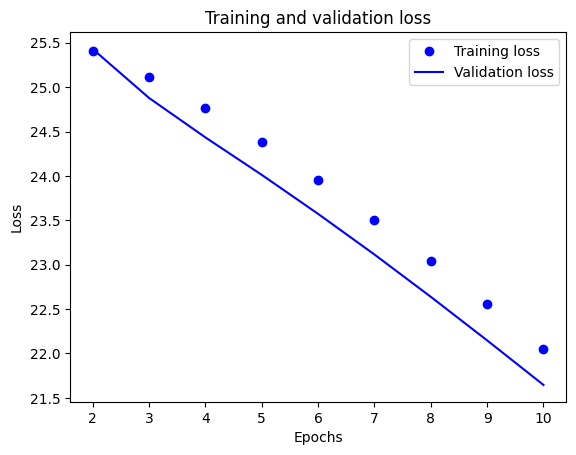

In [33]:
model_test(danq_refined_model(), 10, 2)

Model: "BaselineModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 7999, 4)]         0         
                                                                 
 conv1d_10 (Conv1D)          (None, 7974, 320)         33600     
                                                                 
 batch_normalization_9 (Bat  (None, 7974, 320)         1280      
 chNormalization)                                                
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 613, 320)          0         
 ng1D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 613, 320)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 613, 320)        

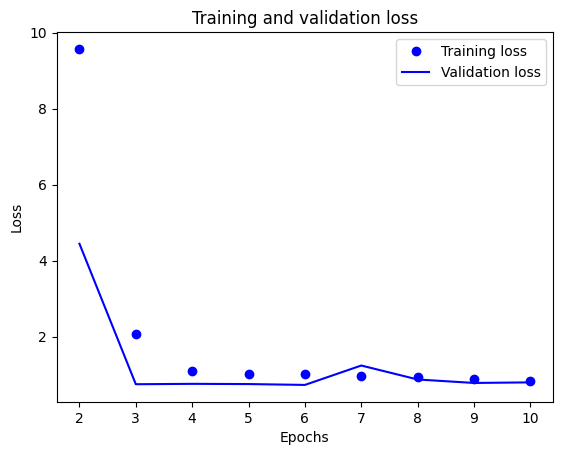

In [34]:
model_test(dan_zrimec_model(), 10, 2)

Model: "AugurModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 7999, 4)]         0         
                                                                 
 conv1d_11 (Conv1D)          (None, 7997, 64)          832       
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67009 (261.75 KB)
Trainable params: 67009 (261.75 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

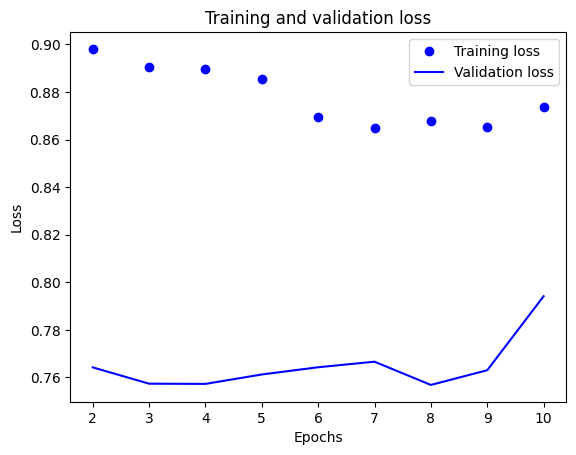

In [35]:
model_test(augur_model(), 10, 2)

### Hyperparameter Tuning

In [50]:
def danq_refined_model_hp_search(hp):
    inputs = layers.Input(shape=(7999, 4))

    conv = layers.Conv1D(
        filters=hp.Int('conv_units', min_value=32, max_value=512, step=32),
        kernel_size=hp.Int('kernel_size', min_value=3, max_value=36, step=3),
        padding='valid',
        activation='relu'
    )(inputs)
    pool = layers.MaxPooling1D(
        pool_size=hp.Int('pool_size', min_value=2, max_value=20, step=2),
        strides=None
    )(conv)
    norm = layers.BatchNormalization()(pool)
    # drop1 = layers.Dropout(
    #     rate=0.2
    # )(pool)

    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=512, step=32), 
            return_sequences=True, 
            recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.05)
        ),
        merge_mode=hp.Choice('merge_mode', ['concat', 'sum', 'mul'])
    )(norm)
    drop2 = layers.Dropout(
        rate=hp.Float('rate', min_value=0.1, max_value=0.5, step=0.05)
    )(bilstm)
    flat = layers.Flatten()(drop2)
    dense1 = layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    )(flat)
    outputs = layers.Dense(
        units=1
    )(dense1)
    
    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='DanQRefModel')

    model.compile(
        loss=keras.losses.MeanSquaredError(),
        # optimizer=keras.optimizers.Adam(learning_rate=0.1, beta_1=0.999, beta_2=0.99, epsilon=1e-6),
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.MeanAbsolutePercentageError(), keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()],
    )
    
    return model

In [51]:
# verifying that the model compiles
danq_refined_model_hp_search(keras_tuner.HyperParameters())

In [52]:
# setting up the tuner
tuner = keras_tuner.BayesianOptimization(
    hypermodel=danq_refined_model_hp_search,
    objective="val_loss",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    directory="hp_search",
    project_name="PTRaugur",
)

In [53]:
# printing an overview of the tunable parameters
tuner.search_space_summary()

Search space summary
Default search space size: 8
conv_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 36, 'step': 3, 'sampling': 'linear'}
pool_size (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 2, 'sampling': 'linear'}
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
recurrent_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
merge_mode (Choice)
{'default': 'concat', 'conditions': [], 'values': ['concat', 'sum', 'mul'], 'ordered': False}
rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 

In [54]:
# setting up an early stop callback function while tuning
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]

# running the tuning
tuner.search(
    X_train, y_train,
    batch_size=64, 
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=2,
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
384               |384               |conv_units
24                |24                |kernel_size
8                 |8                 |pool_size
320               |320               |lstm_units
0.15              |0.15              |recurrent_dropout
sum               |sum               |merge_mode
0.15              |0.15              |rate
64                |64                |dense_units

Epoch 1/100


KeyboardInterrupt: 

### Tests

In [ ]:
# both zrimec and danq have a really bad performance (at least with 5 iterations, danq is slow because it's big)
# model = zrimec_model()
# model = danq_model()
# model = baseline_model()
# model = augur_model()

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, 'baseline.png')
# img = plt.imread('baseline.png')
# plt.figure(figsize=(10,10))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [ ]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.1, beta_1=0.999, beta_2=0.99, epsilon=1e-6),
    metrics=[keras.metrics.MeanAbsolutePercentageError(), keras.metrics.RootMeanSquaredError(), keras.losses.MeanSquaredError(), keras.metrics.MeanAbsoluteError()],
)

# LOSS
# works keras.losses.MeanSquaredError(),

# METRIC
# useless keras.metrics.Accuracy(), 

In [ ]:
callbacks = [
    # keras.callbacks.ModelCheckpoint("PTR_baseline.keras", save_best_only=True)
]

In [ ]:
# alternative methode to prepadding the sequences
# X_train_ragged = tf.ragged.constant(X_train, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
# dataset = tf.data.Dataset.from_tensor_slices(tensor)
# dataset = dataset.map(lambda x: x)

In [ ]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=64, 
    epochs=10, 
    validation_data=(X_val, y_val), 
    callbacks=callbacks
)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(y_test[0], y_pred[0])

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
plot_loss(history)

In [ ]:
def full_model():
    # input
    inputs = keras.Input(shape=(None, 10))
    # 1D convolution
    conv = keras.Conv1D(
        filters=128, 
        kernel_size=10, 
        strides=1, 
        activation='relu'
    )(inputs)
    # batch normalization
    norm = keras.BatchNormalization()(conv)
    # maxpool
    pool = keras.MaxPooling1D(
        pool_size=4,
        strides=4
    )(norm)
    # dropout
    drop = keras.Dropout(rate=0.2)(pool)
    # bi-directional LSTM
    bilstm = keras.Bidirectional(
        keras.LSTM(
            units=128,
            dropout=0
        ),
        merge_mode='concat'
    )(drop)
    # batch normalization
    norm = keras.BatchNormalization()(bilstm)
    # maxpool
    pool = keras.MaxPooling1D(
        pool_size=4,
        strides=4
    )(norm)
    # dropout
    drop = keras.Dropout(rate=0.2)(pool)
    # flatten
    flat = keras.Flatten()(drop)

    # second input
    inputs2 = keras.Input(shape=(29,))

    # concatenation
    conc = keras.Concatenate(axis=1)([inputs, inputs2])

    # fully connected
    dense = keras.Dense(
        units=64,
        activation='relu'
    )(conc)
    # batch normalization
    norm = keras.BatchNormalization()(dense)
    # dropout
    drop = keras.Dropout(rate=0.2)(norm)
    # dense
    outputs = keras.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=[inputs, inputs2], outputs=outputs, name='full_model')
    
    return model